# Dimensionality reduction : Autoencoder (AE)

# Import packages and data

pip install torch

pip install opencv-python

pip install umap-learn

In [1]:
import os
import pandas as pd
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
# for scaling
from sklearn.preprocessing import MinMaxScaler
#for AE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.autograd import Variable
#for visualization
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.manifold import TSNE

Check if GPUs are available :

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Import data:

In [6]:
counts = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/DPLFC_151507_counts_with_probes.csv", index_col=0)

In [7]:
counts

,Unnamed: 0.1,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,y_coord,x_coord
0,AAACAACGAATAGTTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2514,3276
1,AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8520,9178
2,AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2878,5133
3,AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9581,3462
4,AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7663,2779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6239,7464
4222,TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9466,5045
4223,TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9703,4218
4224,TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7906,4017


In [8]:
counts = counts.rename(columns = {"Unnamed: 0.1": "probes"})
counts = counts.set_index("probes")


In [9]:
counts_wo_xy = counts.drop(columns=["y_coord","x_coord"])
counts_wo_xy

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
probes,,,,,,,,,,,,,,,,,,,,,
AAACAACGAATAGTTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Standardization

In [3]:
def scale_datasets(x):
    """
    Standard Scale test and train data
    """
    standard_scaler = MinMaxScaler()
    x_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x),
      columns=x.columns
    )
    return x_scaled

In [13]:
x_scaled = scale_datasets(counts_wo_xy)

# Build Autoencoder

In [14]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # input shape ==> 10
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(x_scaled.shape[1], 10000),
            torch.nn.ReLU(),
            #torch.nn.Linear(20000, 10000),
            #torch.nn.ReLU(),
            torch.nn.Linear(10000, 5000),
            torch.nn.ReLU(),
            torch.nn.Linear(5000, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 5000),
            torch.nn.ReLU(),
            torch.nn.Linear(5000, 10000),
            torch.nn.ReLU(),
            #torch.nn.Linear(10000, 20000),
            #torch.nn.ReLU(),
            torch.nn.Linear(10000, x_scaled.shape[1]),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Model Initialization

In [27]:
model = AE()

In [28]:
n_epochs = 10
batch_size = 200
data_tensor = torch.Tensor(x_scaled.values)
train = torch.utils.data.TensorDataset(data_tensor, data_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

[1,    22] loss: 0.2388
[2,    22] loss: 0.2146
[3,    22] loss: 0.0844
[4,    22] loss: 0.0064
[5,    22] loss: 0.0055
[6,    22] loss: 0.0054
[7,    22] loss: 0.0054
[8,    22] loss: 0.0054
[9,    22] loss: 0.0054
[10,    22] loss: 0.0053
Finished Training


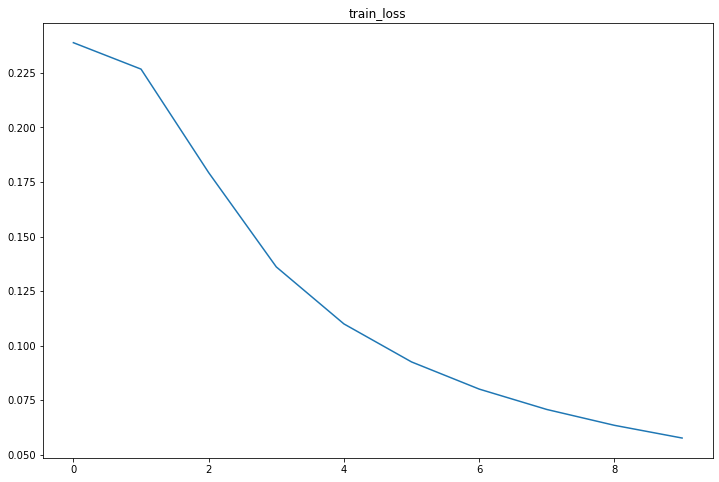

In [29]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00001)

losses = []
train_loss=[]
train_epoch_loss = []
for epoch in range(n_epochs):
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs.to(device)

        # forward pass
        outputs = model(inputs)
        
        # defining loss
        loss = criterion(outputs, inputs)
        
        # zero to parameter gradients
        optimizer.zero_grad()

        # computing gradients
        loss.backward()
        
        # accumulating running loss
        running_loss += loss.item()
        
        # updated weights based on computed gradients
        optimizer.step()

        losses.append(loss)
        train_loss.append(loss.item())

    train_epoch_loss.append(np.array(train_loss).mean())
        
    print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / (i + 1)))

print('Finished Training')
plt.figure(figsize=(12, 8))
plt.plot(train_epoch_loss)
plt.title('train_loss')
plt.show()

In [26]:
from torchsummary import summary
summary(model.cuda(), (x_scaled.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1          [-1, 4226, 10000]     335,390,000
              ReLU-2          [-1, 4226, 10000]               0
            Linear-3           [-1, 4226, 5000]      50,005,000
              ReLU-4           [-1, 4226, 5000]               0
            Linear-5           [-1, 4226, 1000]       5,001,000
              ReLU-6           [-1, 4226, 1000]               0
            Linear-7            [-1, 4226, 100]         100,100
              ReLU-8            [-1, 4226, 100]               0
            Linear-9             [-1, 4226, 10]           1,010
           Linear-10            [-1, 4226, 100]           1,100
             ReLU-11            [-1, 4226, 100]               0
           Linear-12           [-1, 4226, 1000]         101,000
             ReLU-13           [-1, 4226, 1000]               0
           Linear-14           [-1, 422

## Get latent space

In [15]:
def get_embeddings(_data_in, _model, _size_latent_layer):
    
    data_tensor = torch.Tensor(_data_in.values)
    train = torch.utils.data.TensorDataset(data_tensor, data_tensor)
    train_loader = torch.utils.data.DataLoader(train, batch_size=_data_in.shape[0], shuffle=False)
    
    _embeddings = np.zeros((_data_in.shape[0], _size_latent_layer))
    for i, data in enumerate(train_loader):
        inputs, _ = data
        _embeddings = _model.encoder(inputs).cpu().detach().numpy()
        
    return _embeddings

In [16]:
latent_space = get_embeddings(x_scaled, model, 10)
latent_space

array([[ 1.6546642 , -0.6730922 ,  2.4258957 , ...,  5.6805596 ,
         3.7244308 , -0.35191917],
       [ 6.193448  , -2.8027205 ,  9.458835  , ..., 22.227602  ,
        14.670843  , -1.1277337 ],
       [ 2.8254242 , -1.2197933 ,  4.2381153 , ...,  9.94643   ,
         6.547891  , -0.55382454],
       ...,
       [ 1.4637753 , -0.58458775,  2.1274436 , ...,  4.981764  ,
         3.2620032 , -0.31804925],
       [ 4.5369024 , -2.024679  ,  6.888173  , ..., 16.183874  ,
        10.673028  , -0.8460711 ],
       [ 3.3973393 , -1.4917605 ,  5.1256204 , ..., 12.032039  ,
         7.927769  , -0.65096295]], dtype=float32)

## Save latent space

In [17]:
df_latent_space = pd.DataFrame(latent_space, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df_latent_space.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,1.654664,-0.673092,2.425896,-1.483760,-4.482498,-0.191414,0.406959,5.680560,3.724431,-0.351919
1,6.193448,-2.802721,9.458835,-6.058280,-17.244133,-1.000907,1.559313,22.227602,14.670843,-1.127734
2,2.825424,-1.219793,4.238115,-2.664030,-7.772860,-0.399962,0.703683,9.946430,6.547891,-0.553825
3,5.711504,-2.573211,8.705976,-5.573372,-15.888317,-0.916638,1.437945,20.459848,13.509497,-1.048710
4,4.218671,-1.876196,6.396073,-4.064845,-11.692710,-0.646941,1.059009,15.026652,9.905264,-0.791395


In [18]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space"
os.makedirs(sevenbg_output_path, exist_ok=True)
df_latent_space.to_csv(f"{sevenbg_output_path}/DPLFC_151507_latent_space.csv")

## Visualize DR

In [16]:
def compute_dimensionality_reduction(df, df_meta, method):
    
    if method == 'PCA':
        pca = PCA(n_components = 2)
        reduced = pca.fit_transform(df)
    
    if method == 'TSNE':
        tsne = TSNE(n_components = 2)
        reduced = tsne.fit_transform(df)
    
    if method == 'UMAP':
        umap_method = umap.UMAP()
        reduced = umap_method.fit_transform(df)
    
    df_reduced = pd.DataFrame({'X1': reduced[:, 0], 'X2': reduced[:, 1]})
    
    return pd.concat([df_meta, df_reduced], axis=1)

In [20]:
df_embeddings_pca = compute_dimensionality_reduction(latent_space, x_scaled, method = 'PCA')
df_embeddings_pca.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11.792109,-0.000344
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.793036,0.003180
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.195467,-0.001491
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.067830,-0.003500
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.658231,0.001977


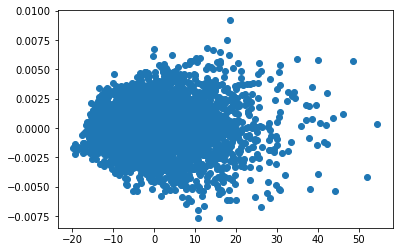

In [21]:
plt.scatter(df_embeddings_pca["X1"], df_embeddings_pca["X2"])

In [22]:
df_embeddings_UMAP = compute_dimensionality_reduction(latent_space, x_scaled, method = 'UMAP')
df_embeddings_UMAP.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.795163,14.272658
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.626550,14.400933
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.438406,1.994902
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.065236,11.661221
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.781616,-2.108055


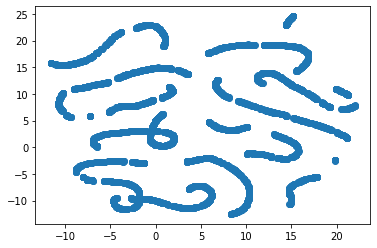

In [23]:
plt.scatter(df_embeddings_UMAP["X1"], df_embeddings_UMAP["X2"])

In [24]:
df_embeddings_tsne = compute_dimensionality_reduction(latent_space, x_scaled, method = 'TSNE')
df_embeddings_tsne.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.776868,31.934397
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.075504,17.640118
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.188137,-60.367504
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.300569,-2.342664
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.311274,-26.497671


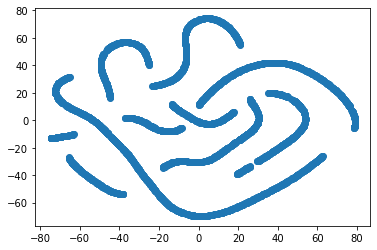

In [25]:
plt.scatter(df_embeddings_tsne["X1"], df_embeddings_tsne["X2"])

# Perfom on DPLFC datasets

## 151673

In [10]:
counts_151673 = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/DPLFC_151673_counts_with_probes.csv", index_col=0)

In [11]:
counts_151673

,Unnamed: 0.1,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,y_coord,x_coord
0,AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8468,9791
1,AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2807,5769
2,AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9505,4068
3,AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4151,9271
4,AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7583,3393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9396,5653
3635,TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9630,4825
3636,TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7831,4631
3637,TTGTTTGTATTACACG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11193,5571


In [13]:
counts_151673 = counts_151673.rename(columns = {"Unnamed: 0.1": "probes"})
counts_151673 = counts_151673.set_index("probes")
counts_wo_xy = counts_151673.drop(columns=["y_coord","x_coord"])

In [14]:
counts_wo_xy

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
probes,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
x_scaled = scale_datasets(counts_wo_xy)

In [16]:
model = AE()

In [17]:
n_epochs = 10
batch_size = 200
data_tensor = torch.Tensor(x_scaled.values)
train = torch.utils.data.TensorDataset(data_tensor, data_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

[1,    19] loss: 0.2356
[2,    19] loss: 0.2174
[3,    19] loss: 0.1080
[4,    19] loss: 0.0100
[5,    19] loss: 0.0074
[6,    19] loss: 0.0074
[7,    19] loss: 0.0072
[8,    19] loss: 0.0074
[9,    19] loss: 0.0073
[10,    19] loss: 0.0072
Finished Training


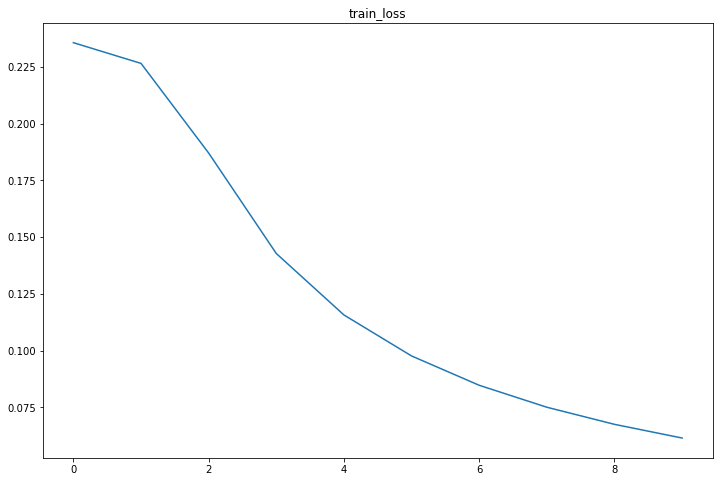

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00001)

losses = []
train_loss=[]
train_epoch_loss = []
for epoch in range(n_epochs):
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs.to(device)

        # forward pass
        outputs = model(inputs)
        
        # defining loss
        loss = criterion(outputs, inputs)
        
        # zero to parameter gradients
        optimizer.zero_grad()

        # computing gradients
        loss.backward()
        
        # accumulating running loss
        running_loss += loss.item()
        
        # updated weights based on computed gradients
        optimizer.step()

        losses.append(loss)
        train_loss.append(loss.item())

    train_epoch_loss.append(np.array(train_loss).mean())
        
    print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / (i + 1)))

print('Finished Training')
plt.figure(figsize=(12, 8))
plt.plot(train_epoch_loss)
plt.title('train_loss')
plt.show()

In [21]:
latent_space = get_embeddings(x_scaled, model, 10)
latent_space

array([[ 21.807194 ,   2.5670292,  18.867867 , ..., -12.771133 ,
         11.1817665, -12.429247 ],
       [  4.9636445,   0.535576 ,   4.1818314, ...,  -2.9230468,
          2.5609183,  -2.8622522],
       [ 10.3895235,   1.186608 ,   8.911389 , ...,  -6.0986724,
          5.3362546,  -5.943906 ],
       ...,
       [  5.7150693,   0.6249742,   4.838155 , ...,  -3.364617 ,
          2.9455357,  -3.2893472],
       [  6.489996 ,   0.7214562,   5.5145254, ...,  -3.8158443,
          3.3444004,  -3.7295132],
       [ 16.619621 ,   1.9382153,  14.349214 , ...,  -9.739728 ,
          8.52877  ,  -9.483728 ]], dtype=float32)

In [22]:
df_latent_space = pd.DataFrame(latent_space, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df_latent_space.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,21.807194,2.567029,18.867867,-10.539822,18.429331,23.193333,-2.492150,-12.771133,11.181767,-12.429247
1,4.963645,0.535576,4.181831,-2.415662,4.203759,5.209476,-0.629136,-2.923047,2.560918,-2.862252
2,10.389524,1.186608,8.911389,-5.034423,8.785227,11.000340,-1.229374,-6.098672,5.336255,-5.943906
3,12.620265,1.456959,10.859351,-6.111197,10.668478,13.383902,-1.475507,-7.401599,6.479130,-7.211139
4,11.459588,1.318880,9.847275,-5.549852,9.691551,12.145718,-1.349747,-6.722358,5.886029,-6.552395


In [23]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space"
os.makedirs(sevenbg_output_path, exist_ok=True)
df_latent_space.to_csv(f"{sevenbg_output_path}/DPLFC_151673_latent_space.csv")

In [26]:
df_embeddings_pca = compute_dimensionality_reduction(latent_space, x_scaled, method = 'PCA')
df_embeddings_pca.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.968981,0.000710
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.930865,-0.001015
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.045643,-0.000860
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.843274,-0.000397
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.697592,-0.000875


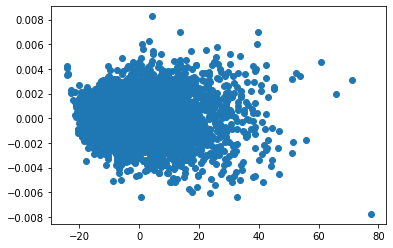

In [27]:
plt.scatter(df_embeddings_pca["X1"], df_embeddings_pca["X2"])

In [28]:
df_embeddings_UMAP = compute_dimensionality_reduction(latent_space, x_scaled, method = 'UMAP')
df_embeddings_UMAP.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.963913,-6.875093
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.964125,-5.845837
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.437444,23.673874
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.861348,10.692810
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.482134,16.770187


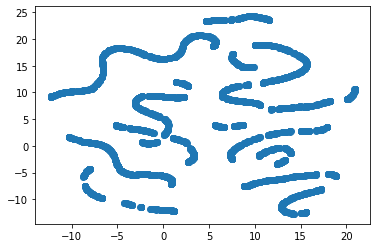

In [29]:
plt.scatter(df_embeddings_UMAP["X1"], df_embeddings_UMAP["X2"])

In [30]:
df_embeddings_tsne = compute_dimensionality_reduction(latent_space, x_scaled, method = 'TSNE')
df_embeddings_tsne.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-58.071301,27.328300
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-39.583832,12.526501
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.521990,-45.788269
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.155405,-75.911957
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.676579,-19.417048


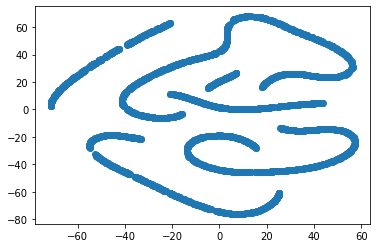

In [31]:
plt.scatter(df_embeddings_tsne["X1"], df_embeddings_tsne["X2"])

In [32]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/pca_umap_tsne"
os.makedirs(sevenbg_output_path, exist_ok=True)
df_embeddings_pca.to_csv(f"{sevenbg_output_path}/DPLFC_151673_df_embeddings_pca.csv")
df_embeddings_UMAP.to_csv(f"{sevenbg_output_path}/DPLFC_151673_df_embeddings_UMAP.csv")
df_embeddings_tsne.to_csv(f"{sevenbg_output_path}/DPLFC_151673_df_embeddings_tsne.csv")

## 151508

In [33]:
counts = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/DPLFC_151508_counts_with_probes.csv", index_col=0)
counts = counts.rename(columns = {"Unnamed: 0.1": "probes"})
counts = counts.set_index("probes")
counts_wo_xy = counts.drop(columns=["y_coord","x_coord"])

In [34]:
x_scaled = scale_datasets(counts_wo_xy)

In [35]:
model = AE()

In [36]:
n_epochs = 10
batch_size = 200
data_tensor = torch.Tensor(x_scaled.values)
train = torch.utils.data.TensorDataset(data_tensor, data_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

In [37]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00001)

losses = []
train_loss=[]
train_epoch_loss = []
for epoch in range(n_epochs):
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs.to(device)

        # forward pass
        outputs = model(inputs)
        
        # defining loss
        loss = criterion(outputs, inputs)
        
        # zero to parameter gradients
        optimizer.zero_grad()

        # computing gradients
        loss.backward()
        
        # accumulating running loss
        running_loss += loss.item()
        
        # updated weights based on computed gradients
        optimizer.step()

        losses.append(loss)
        train_loss.append(loss.item())

    train_epoch_loss.append(np.array(train_loss).mean())
        
    print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / (i + 1)))

print('Finished Training')
plt.figure(figsize=(12, 8))
plt.plot(train_epoch_loss)
plt.title('train_loss')
plt.show()

[1,    22] loss: 0.2402
[2,    22] loss: 0.2180


KeyboardInterrupt: 

In [ ]:
latent_space = get_embeddings(x_scaled, model, 10)
latent_space

In [ ]:
df_latent_space = pd.DataFrame(latent_space, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df_latent_space.head()

In [ ]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space"
os.makedirs(sevenbg_output_path, exist_ok=True)
df_latent_space.to_csv(f"{sevenbg_output_path}/DPLFC_151508_latent_space.csv")

In [ ]:
df_embeddings_pca = compute_dimensionality_reduction(latent_space, x_scaled, method = 'PCA')
df_embeddings_pca.head()

In [ ]:
plt.scatter(df_embeddings_pca["X1"], df_embeddings_pca["X2"])

In [ ]:
df_embeddings_UMAP = compute_dimensionality_reduction(latent_space, x_scaled, method = 'UMAP')
df_embeddings_UMAP.head()

In [ ]:
plt.scatter(df_embeddings_UMAP["X1"], df_embeddings_UMAP["X2"])

In [ ]:
df_embeddings_tsne = compute_dimensionality_reduction(latent_space, x_scaled, method = 'TSNE')
df_embeddings_tsne.head()

In [ ]:
plt.scatter(df_embeddings_tsne["X1"], df_embeddings_tsne["X2"])

In [ ]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/pca_umap_tsne"
os.makedirs(sevenbg_output_path, exist_ok=True)
df_embeddings_pca.to_csv(f"{sevenbg_output_path}/DPLFC_151508_df_embeddings_pca.csv")
df_embeddings_UMAP.to_csv(f"{sevenbg_output_path}/DPLFC_151508_df_embeddings_UMAP.csv")
df_embeddings_tsne.to_csv(f"{sevenbg_output_path}/DPLFC_151508_df_embeddings_tsne.csv")

## 151669

In [72]:
counts = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/DPLFC_151669_counts_with_probes.csv", index_col=0)
counts = counts.rename(columns = {"Unnamed: 0.1": "probes"})
counts = counts.set_index("probes")
counts_wo_xy = counts.drop(columns=["y_coord","x_coord"])

In [73]:
x_scaled = scale_datasets(counts_wo_xy)

In [74]:
model = AE()

In [75]:
n_epochs = 10
batch_size = 200
data_tensor = torch.Tensor(x_scaled.values)
train = torch.utils.data.TensorDataset(data_tensor, data_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

In [76]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00001)

losses = []
for epoch in range(n_epochs):
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs.to(device)

        # forward pass
        outputs = model(inputs)
        
        # defining loss
        loss = criterion(outputs, inputs)
        
        # zero to parameter gradients
        optimizer.zero_grad()

        # computing gradients
        loss.backward()
        
        # accumulating running loss
        running_loss += loss.item()
        
        # updated weights based on computed gradients
        optimizer.step()

        losses.append(loss)
        
    print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / (i + 1)))

[1,    19] loss: 0.2377
[2,    19] loss: 0.2213
[3,    19] loss: 0.1210
[4,    19] loss: 0.0104
[5,    19] loss: 0.0065
[6,    19] loss: 0.0064
[7,    19] loss: 0.0064
[8,    19] loss: 0.0064
[9,    19] loss: 0.0064
[10,    19] loss: 0.0064


In [77]:
latent_space = get_embeddings(x_scaled, model, 10)
latent_space

array([[-3.23789865e-02, -3.70804358e+00,  2.62519493e+01, ...,
         1.42078333e+01, -4.86163497e-01, -1.32968082e+01],
       [ 1.88074559e-02, -2.37097049e+00,  1.68680668e+01, ...,
         9.13345337e+00, -2.95369297e-01, -8.54561329e+00],
       [ 4.78474088e-02, -1.53347397e+00,  1.10036125e+01, ...,
         5.95910215e+00, -1.76795483e-01, -5.58063221e+00],
       ...,
       [ 9.50008631e-03, -2.58208466e+00,  1.83568745e+01, ...,
         9.93725491e+00, -3.23063076e-01, -9.30099010e+00],
       [ 3.45875025e-02, -1.87438381e+00,  1.33794422e+01, ...,
         7.24414062e+00, -2.25382507e-01, -6.78272390e+00],
       [ 6.15285188e-02, -1.18434632e+00,  8.55368137e+00, ...,
         4.63283491e+00, -1.27133384e-01, -4.33805323e+00]], dtype=float32)

In [78]:
df_latent_space = pd.DataFrame(latent_space, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df_latent_space.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,-0.032379,-3.708044,26.251949,-26.551332,-1.890461,-8.461801,-6.867267,14.207833,-0.486163,-13.296808
1,0.018807,-2.370970,16.868067,-17.054436,-1.200498,-5.391017,-4.414094,9.133453,-0.295369,-8.545613
2,0.047847,-1.533474,11.003613,-11.122798,-0.773004,-3.474298,-2.882514,5.959102,-0.176795,-5.580632
3,-0.020717,-3.449575,24.450558,-24.728966,-1.753689,-7.869233,-6.392747,13.234563,-0.449039,-12.378954
4,-0.042100,-4.030537,28.529696,-28.860031,-2.050231,-9.205667,-7.460717,15.440269,-0.530929,-14.447659


In [79]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space"
os.makedirs(sevenbg_output_path, exist_ok=True)
df_latent_space.to_csv(f"{sevenbg_output_path}/DPLFC_151669_latent_space.csv")

In [80]:
df_embeddings_pca = compute_dimensionality_reduction(latent_space, x_scaled, method = 'PCA')
df_embeddings_pca.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.742086,-0.003385
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.111341,-0.001927
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.654023,-0.001926
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.738981,-0.001525
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.536697,0.000746


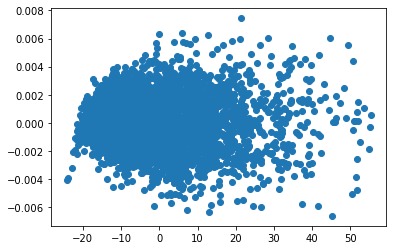

In [81]:
plt.scatter(df_embeddings_pca["X1"], df_embeddings_pca["X2"])

In [82]:
df_embeddings_UMAP = compute_dimensionality_reduction(latent_space, x_scaled, method = 'UMAP')
df_embeddings_UMAP.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.831139,13.244508
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.858856,2.141028
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.255595,-2.779353
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.010441,11.564178
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.899977,17.530710


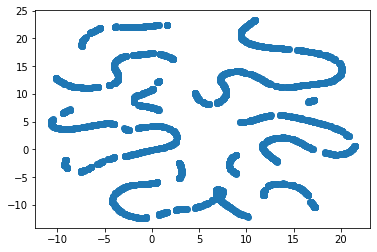

In [83]:
plt.scatter(df_embeddings_UMAP["X1"], df_embeddings_UMAP["X2"])

In [84]:
df_embeddings_tsne = compute_dimensionality_reduction(latent_space, x_scaled, method = 'TSNE')
df_embeddings_tsne.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.360722,21.745981
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-26.328794,-48.879681
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-76.401939,-7.760323
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.125061,7.350600
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.733139,44.779896


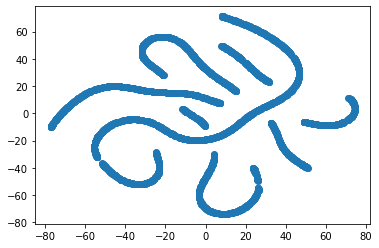

In [85]:
plt.scatter(df_embeddings_tsne["X1"], df_embeddings_tsne["X2"])

# Mouse brain

In [10]:
counts = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/V1_Mouse_Brain_Sagittal_Anterior_counts_with_probes.csv", index_col=0)
counts = counts.rename(columns = {"Unnamed: 0.1": "probes"})
counts = counts.set_index("probes")
counts_wo_xy = counts.drop(columns=["y_coord","x_coord"])

In [11]:
counts.shape

(2695, 32287)

In [12]:
x_scaled = scale_datasets(counts_wo_xy)

In [22]:
model = AE()

In [23]:
n_epochs = 10
batch_size = 200
data_tensor = torch.Tensor(x_scaled.values)
train = torch.utils.data.TensorDataset(data_tensor, data_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

[1,    14] loss: 0.2200
[2,    14] loss: 0.2135
[3,    14] loss: 0.1830
[4,    14] loss: 0.0655
[5,    14] loss: 0.0183
[6,    14] loss: 0.0157
[7,    14] loss: 0.0150
[8,    14] loss: 0.0146
[9,    14] loss: 0.0144
[10,    14] loss: 0.0142
Finished Training


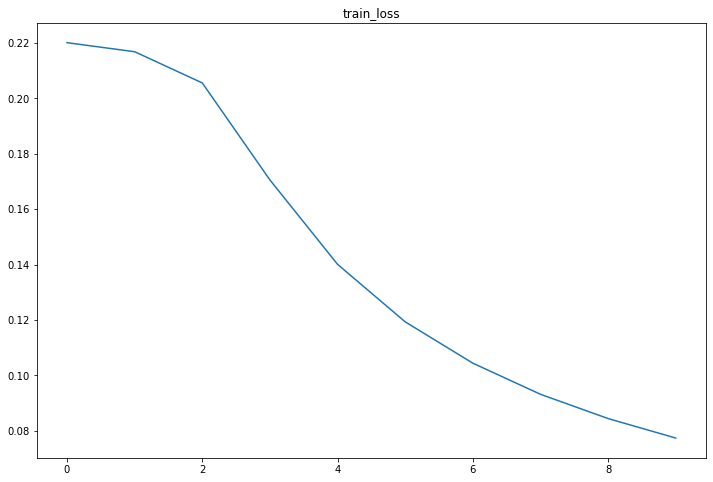

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00001)

train_loss = []
train_epoch_loss =[]
losses = []
for epoch in range(n_epochs):
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs.to(device)

        # forward pass
        outputs = model(inputs)
        
        # defining loss
        loss = criterion(outputs, inputs)
        
        # zero to parameter gradients
        optimizer.zero_grad()

        # computing gradients
        loss.backward()
        
        # accumulating running loss
        running_loss += loss.item()
        
        # updated weights based on computed gradients
        optimizer.step()

        losses.append(loss)
        train_loss.append(loss.item())
    train_epoch_loss.append(np.array(train_loss).mean())
    
    print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / (i + 1)))
    
       


print('Finished Training')
plt.figure(figsize=(12, 8))
plt.plot(train_epoch_loss)
plt.title('train_loss')
plt.show()

In [25]:
latent_space = get_embeddings(x_scaled, model, 10)
latent_space

array([[ -0.57312614,   8.515974  ,  -2.523334  , ...,  -5.6869884 ,
          8.842394  ,   0.21936537],
       [ -1.7413563 ,  26.674007  ,  -7.685328  , ..., -17.7107    ,
         27.59675   ,   0.6987715 ],
       [ -1.0915053 ,  16.597954  ,  -4.825043  , ..., -11.035514  ,
         17.179129  ,   0.43358833],
       ...,
       [ -0.91679585,  13.8331175 ,  -4.0387096 , ...,  -9.207987  ,
         14.327358  ,   0.36130035],
       [ -0.5782854 ,   8.586126  ,  -2.5479457 , ...,  -5.731052  ,
          8.9091    ,   0.22168332],
       [ -0.61757857,   9.194812  ,  -2.7198815 , ...,  -6.135011  ,
          9.539076  ,   0.2401846 ]], dtype=float32)

In [26]:
df_latent_space = pd.DataFrame(latent_space, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df_latent_space.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,-0.573126,8.515974,-2.523334,-7.038520,-3.723629,13.069116,-1.607762,-5.686988,8.842394,0.219365
1,-1.741356,26.674007,-7.685328,-22.076292,-11.563720,41.046898,-5.159363,-17.710699,27.596750,0.698771
2,-1.091505,16.597954,-4.825043,-13.725579,-7.214374,25.516869,-3.187452,-11.035514,17.179129,0.433588
3,-1.903581,29.103045,-8.372910,-24.098562,-12.617466,44.792721,-5.645346,-19.324207,30.114601,0.765375
4,-1.728412,26.482843,-7.631544,-21.918812,-11.480980,40.752972,-5.124880,-17.584368,27.399649,0.695698


In [27]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space"
os.makedirs(sevenbg_output_path, exist_ok=True)
df_latent_space.to_csv(f"{sevenbg_output_path}/mouse_brain_latent_space.csv")

In [28]:
df_embeddings_pca = compute_dimensionality_reduction(latent_space, x_scaled, method = 'PCA')
df_embeddings_pca.head()

,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1,...,AC163611.2,AC140365.1,AC124606.2,AC124606.1,AC133095.2,AC133095.1,AC234645.1,AC149090.1,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,-15.488822,0.006497
1,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.111111,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21875,28.525103,0.001397
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15625,4.091352,-0.003941
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50000,34.425426,0.011621
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46875,28.062889,0.002865


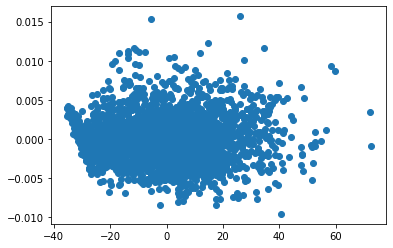

In [29]:
plt.scatter(df_embeddings_pca["X1"], df_embeddings_pca["X2"])

In [30]:
df_embeddings_UMAP = compute_dimensionality_reduction(latent_space, x_scaled, method = 'UMAP')
df_embeddings_UMAP.head()

,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1,...,AC163611.2,AC140365.1,AC124606.2,AC124606.1,AC133095.2,AC133095.1,AC234645.1,AC149090.1,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,-10.367912,6.409142
1,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.111111,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21875,13.461992,20.756161
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15625,9.681615,-2.427809
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50000,16.413958,18.627836
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46875,13.081537,20.816614


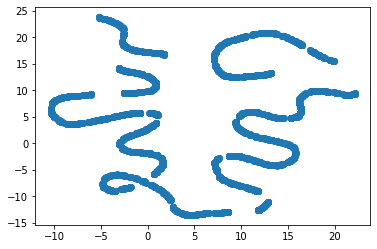

In [31]:
plt.scatter(df_embeddings_UMAP["X1"], df_embeddings_UMAP["X2"])

In [32]:
df_embeddings_tsne = compute_dimensionality_reduction(latent_space, x_scaled, method = 'TSNE')
df_embeddings_tsne.head()

,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1,...,AC163611.2,AC140365.1,AC124606.2,AC124606.1,AC133095.2,AC133095.1,AC234645.1,AC149090.1,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,15.515086,-65.636093
1,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.111111,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21875,-8.342257,-34.520409
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15625,-20.447552,26.019489
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50000,-17.540058,-26.850212
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46875,-7.387648,-35.164764


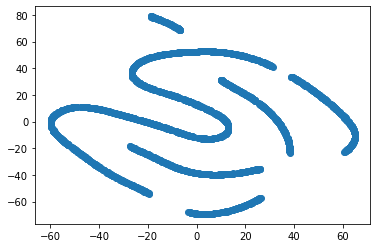

In [33]:
plt.scatter(df_embeddings_tsne["X1"], df_embeddings_tsne["X2"])

# PDAC

## A1

In [105]:
counts = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/A1_counts_with_probes.csv", index_col=0)
counts = counts.rename(columns = {"Unnamed: 0.1": "probes"})
counts = counts.set_index("probes")
counts_wo_xy = counts.drop(columns=["y_coord","x_coord"])

In [106]:
x_scaled = scale_datasets(counts_wo_xy)

In [107]:
model = AE()

In [108]:
n_epochs = 10
batch_size = 200
data_tensor = torch.Tensor(x_scaled.values)
train = torch.utils.data.TensorDataset(data_tensor, data_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

[1,    12] loss: 0.2345
[2,    12] loss: 0.2298
[3,    12] loss: 0.2190
[4,    12] loss: 0.1897
[5,    12] loss: 0.0968
[6,    12] loss: 0.0197
[7,    12] loss: 0.0112
[8,    12] loss: 0.0106
[9,    12] loss: 0.0105
[10,    12] loss: 0.0105
Finished Training


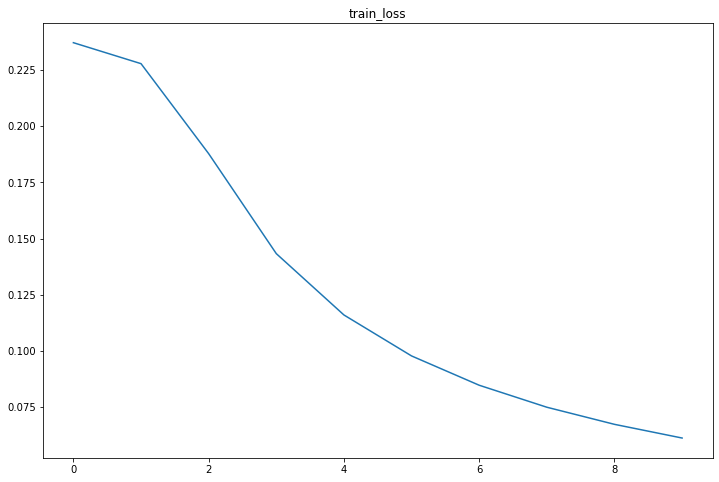

In [109]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00001)

losses = []
for epoch in range(n_epochs):
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs.to(device)

        # forward pass
        outputs = model(inputs)
        
        # defining loss
        loss = criterion(outputs, inputs)
        
        # zero to parameter gradients
        optimizer.zero_grad()

        # computing gradients
        loss.backward()
        
        # accumulating running loss
        running_loss += loss.item()
        
        # updated weights based on computed gradients
        optimizer.step()

        losses.append(loss)
        
    print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / (i + 1)))
print('Finished Training')
plt.figure(figsize=(12, 8))
plt.plot(train_epoch_loss)
plt.title('train_loss')
plt.show()

In [110]:
latent_space = get_embeddings(x_scaled, model, 10)
latent_space

array([[ -3.3654985 ,  -3.942737  ,   6.8845644 , ...,  -8.401478  ,
          2.3929367 ,  -4.5883937 ],
       [ -5.0551085 ,  -5.873328  ,  10.273596  , ..., -12.501456  ,
          3.5798085 ,  -6.8787594 ],
       [ -3.9040804 ,  -4.55749   ,   7.962971  , ...,  -9.708483  ,
          2.7708428 ,  -5.3160157 ],
       ...,
       [ -4.066185  ,  -4.747066  ,   8.294718  , ..., -10.105195  ,
          2.8837385 ,  -5.54325   ],
       [ -2.4920883 ,  -2.9456263 ,   5.134366  , ...,  -6.285692  ,
          1.7799218 ,  -3.4076905 ],
       [ -0.82456326,  -1.04275   ,   1.788402  , ...,  -2.2414694 ,
          0.6027543 ,  -1.1501868 ]], dtype=float32)

In [111]:
df_latent_space = pd.DataFrame(latent_space, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df_latent_space.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,-3.365499,-3.942737,6.884564,1.325026,-3.942427,8.085510,-6.017630,-8.401478,2.392937,-4.588394
1,-5.055109,-5.873328,10.273596,2.010570,-5.879336,12.040437,-9.005730,-12.501456,3.579808,-6.878759
2,-3.904080,-4.557490,7.962971,1.546562,-4.560051,9.347088,-6.972457,-9.708483,2.770843,-5.316016
3,-4.718240,-5.489657,9.600284,1.874790,-5.492761,11.252047,-8.411410,-11.684543,3.341078,-6.420690
4,-1.457573,-1.764102,3.056021,0.554859,-1.750862,3.617086,-2.649365,-3.772002,1.048451,-2.003154


In [112]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space"
os.makedirs(sevenbg_output_path, exist_ok=True)
df_latent_space.to_csv(f"{sevenbg_output_path}/A1_latent_space.csv")

In [113]:
df_embeddings_pca = compute_dimensionality_reduction(latent_space, x_scaled, method = 'PCA')
df_embeddings_pca.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.083333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.154824,0.001078
1,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231083,-0.002283
2,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.481774,-0.001765
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.560501,-0.002753
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-15.624560,-0.000535


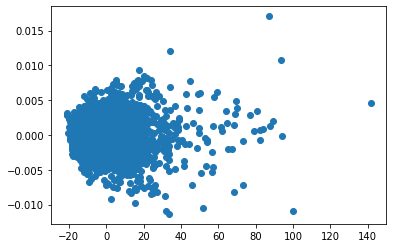

In [114]:
plt.scatter(df_embeddings_pca["X1"], df_embeddings_pca["X2"])

In [115]:
df_embeddings_UMAP = compute_dimensionality_reduction(latent_space, x_scaled, method = 'UMAP')
df_embeddings_UMAP.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.083333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.535951,-3.966386
1,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.264469,0.888016
2,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.134976,-8.776644
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.242486,-5.195623
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.018478,14.906866


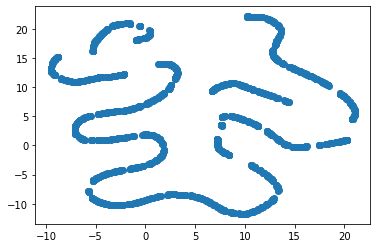

In [116]:
plt.scatter(df_embeddings_UMAP["X1"], df_embeddings_UMAP["X2"])

In [117]:
df_embeddings_tsne = compute_dimensionality_reduction(latent_space, x_scaled, method = 'TSNE')
df_embeddings_tsne.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.083333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.437374,12.832517
1,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29.322163,7.587559
2,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.611330,45.920380
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-48.794533,8.726533
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.354576,-66.423264


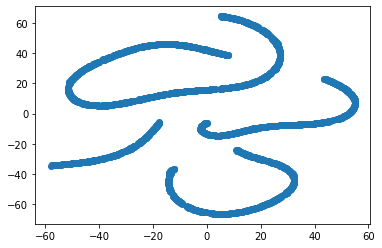

In [118]:
plt.scatter(df_embeddings_tsne["X1"], df_embeddings_tsne["X2"])

## B2

In [119]:
counts = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/B2_counts_with_probes.csv", index_col=0)
counts = counts.rename(columns = {"Unnamed: 0.1": "probes"})
counts = counts.set_index("probes")
counts_wo_xy = counts.drop(columns=["y_coord","x_coord"])

In [120]:
x_scaled = scale_datasets(counts_wo_xy)

In [121]:
model = AE()

In [122]:
n_epochs = 10
batch_size = 200
data_tensor = torch.Tensor(x_scaled.values)
train = torch.utils.data.TensorDataset(data_tensor, data_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

[1,    16] loss: 0.2219
[2,    16] loss: 0.2132
[3,    16] loss: 0.1744
[4,    16] loss: 0.0627
[5,    16] loss: 0.0173
[6,    16] loss: 0.0148
[7,    16] loss: 0.0145
[8,    16] loss: 0.0146
[9,    16] loss: 0.0145
[10,    16] loss: 0.0145
Finished Training


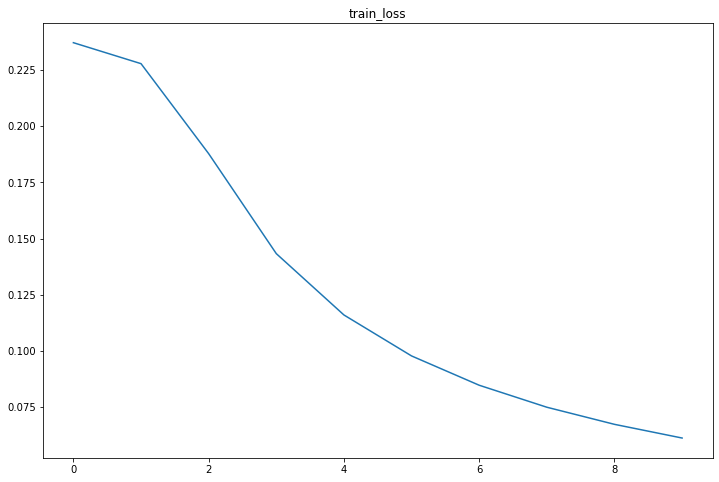

In [123]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00001)

losses = []
for epoch in range(n_epochs):
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs.to(device)

        # forward pass
        outputs = model(inputs)
        
        # defining loss
        loss = criterion(outputs, inputs)
        
        # zero to parameter gradients
        optimizer.zero_grad()

        # computing gradients
        loss.backward()
        
        # accumulating running loss
        running_loss += loss.item()
        
        # updated weights based on computed gradients
        optimizer.step()

        losses.append(loss)
        
    print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / (i + 1)))
print('Finished Training')
plt.figure(figsize=(12, 8))
plt.plot(train_epoch_loss)
plt.title('train_loss')
plt.show()

In [124]:
latent_space = get_embeddings(x_scaled, model, 10)
latent_space

array([[ 2.5458887,  3.2071545,  0.9822547, ...,  4.741512 ,  3.6351554,
         3.217756 ],
       [ 4.2914786,  5.451423 ,  1.6132995, ...,  8.05156  ,  6.2177277,
         5.5405483],
       [13.538921 , 17.37434  ,  4.9575663, ..., 25.652807 , 19.958752 ,
        17.88179  ],
       ...,
       [30.222721 , 38.898773 , 10.990892 , ..., 57.416985 , 44.744392 ,
        40.15088  ],
       [ 5.50084  ,  7.014347 ,  2.048943 , ..., 10.35649  ,  8.024026 ,
         7.155232 ],
       [ 5.5477343,  7.0736203,  2.0688202, ..., 10.449422 ,  8.09064  ,
         7.225304 ]], dtype=float32)

In [125]:
df_latent_space = pd.DataFrame(latent_space, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df_latent_space.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,2.545889,3.207155,0.982255,-0.783378,2.597544,-5.376922,1.251973,4.741512,3.635155,3.217756
1,4.291479,5.451423,1.613299,-1.330593,4.414288,-9.132233,2.200362,8.051560,6.217728,5.540548
2,13.538921,17.374340,4.957566,-4.233988,14.066543,-29.049681,7.230553,25.652807,19.958752,17.881790
3,3.904019,4.950810,1.471782,-1.205345,4.008940,-8.294728,1.986790,7.315683,5.644227,5.025742
4,10.719901,13.743129,3.943208,-3.351948,11.130822,-22.983192,5.698650,20.292442,15.769251,14.124596


In [126]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space"
os.makedirs(sevenbg_output_path, exist_ok=True)
df_latent_space.to_csv(f"{sevenbg_output_path}/B2_latent_space.csv")

In [127]:
df_embeddings_pca = compute_dimensionality_reduction(latent_space, x_scaled, method = 'PCA')
df_embeddings_pca.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.000000,0.0,0.00,0.0,0.1,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29.670097,0.001834
1,0.0,0.000000,0.0,0.25,0.0,0.1,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-22.591578,-0.001132
2,0.0,0.142857,0.0,0.00,0.0,0.1,0.000000,0.058824,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.003432,-0.001891
3,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.058824,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.167391,-0.001124
4,0.0,0.000000,0.0,0.25,0.0,0.0,0.066667,0.176471,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.553156,0.002348


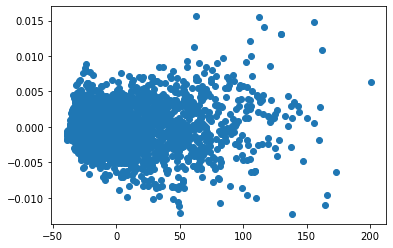

In [128]:
plt.scatter(df_embeddings_pca["X1"], df_embeddings_pca["X2"])

In [129]:
df_embeddings_UMAP = compute_dimensionality_reduction(latent_space, x_scaled, method = 'UMAP')
df_embeddings_UMAP.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.000000,0.0,0.00,0.0,0.1,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.155303,11.086410
1,0.0,0.000000,0.0,0.25,0.0,0.1,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.110407,1.092151
2,0.0,0.142857,0.0,0.00,0.0,0.1,0.000000,0.058824,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.952723,5.184908
3,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.058824,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.433238,-0.551888
4,0.0,0.000000,0.0,0.25,0.0,0.0,0.066667,0.176471,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.764156,1.175090


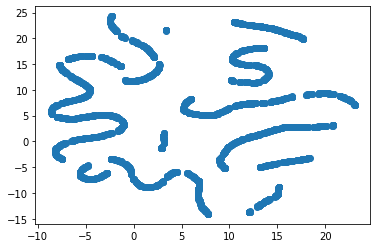

In [130]:
plt.scatter(df_embeddings_UMAP["X1"], df_embeddings_UMAP["X2"])

In [131]:
df_embeddings_tsne = compute_dimensionality_reduction(latent_space, x_scaled, method = 'TSNE')
df_embeddings_tsne.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.000000,0.0,0.00,0.0,0.1,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.602972,-43.814079
1,0.0,0.000000,0.0,0.25,0.0,0.1,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.806301,-25.070408
2,0.0,0.142857,0.0,0.00,0.0,0.1,0.000000,0.058824,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.222206,43.085430
3,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.058824,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.899467,-13.221836
4,0.0,0.000000,0.0,0.25,0.0,0.0,0.066667,0.176471,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.465348,60.340515


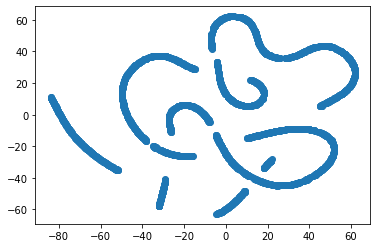

In [132]:
plt.scatter(df_embeddings_tsne["X1"], df_embeddings_tsne["X2"])

## C3

In [133]:
counts = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/C3_counts_with_probes.csv", index_col=0)
counts = counts.rename(columns = {"Unnamed: 0.1": "probes"})
counts = counts.set_index("probes")
counts_wo_xy = counts.drop(columns=["y_coord","x_coord"])

In [134]:
x_scaled = scale_datasets(counts_wo_xy)

In [135]:
model = AE()

In [136]:
n_epochs = 10
batch_size = 200
data_tensor = torch.Tensor(x_scaled.values)
train = torch.utils.data.TensorDataset(data_tensor, data_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

[1,    12] loss: 0.2245
[2,    12] loss: 0.2195
[3,    12] loss: 0.2073
[4,    12] loss: 0.1658
[5,    12] loss: 0.0730
[6,    12] loss: 0.0261
[7,    12] loss: 0.0168
[8,    12] loss: 0.0152
[9,    12] loss: 0.0147
[10,    12] loss: 0.0145
Finished Training


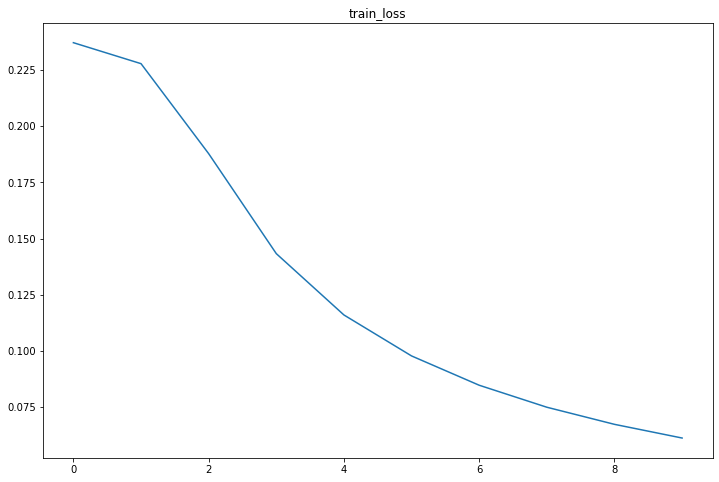

In [137]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00001)

losses = []
for epoch in range(n_epochs):
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs.to(device)

        # forward pass
        outputs = model(inputs)
        
        # defining loss
        loss = criterion(outputs, inputs)
        
        # zero to parameter gradients
        optimizer.zero_grad()

        # computing gradients
        loss.backward()
        
        # accumulating running loss
        running_loss += loss.item()
        
        # updated weights based on computed gradients
        optimizer.step()

        losses.append(loss)
        
    print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / (i + 1)))
print('Finished Training')
plt.figure(figsize=(12, 8))
plt.plot(train_epoch_loss)
plt.title('train_loss')
plt.show()

In [138]:
latent_space = get_embeddings(x_scaled, model, 10)
latent_space

array([[ -3.555757  ,   4.1505575 ,   1.6288614 , ...,   2.1942542 ,
          3.8838332 ,   0.55672956],
       [ -2.3743975 ,   2.755304  ,   1.098838  , ...,   1.4358423 ,
          2.6053424 ,   0.35237765],
       [-22.044977  ,  25.974642  ,   9.937606  , ...,  14.055555  ,
         23.915127  ,   3.7486002 ],
       ...,
       [ -5.348188  ,   6.2668686 ,   2.4355772 , ...,   3.3434505 ,
          5.826247  ,   0.8667385 ],
       [-26.2269    ,  30.916172  ,  11.812818  , ...,  16.745066  ,
         28.43927   ,   4.4717145 ],
       [ -6.3674803 ,   7.4700623 ,   2.8940663 , ...,   4.000262  ,
          6.9311996 ,   1.0423386 ]], dtype=float32)

In [139]:
df_latent_space = pd.DataFrame(latent_space, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df_latent_space.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,-3.555757,4.150558,1.628861,1.246980,-0.080530,1.185952,-3.321806,2.194254,3.883833,0.556730
1,-2.374398,2.755304,1.098838,0.835681,-0.047402,0.750095,-2.230248,1.435842,2.605342,0.352378
2,-22.044977,25.974642,9.937606,7.663164,-0.644623,7.983643,-20.403765,14.055555,23.915127,3.748600
3,-5.248395,6.148057,2.391750,1.834863,-0.135631,1.807740,-4.887560,3.277494,5.719951,0.848997
4,-1.207357,1.376903,0.575267,0.431036,-0.011663,0.320690,-1.150154,0.687002,1.339959,0.150396


In [140]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space"
os.makedirs(sevenbg_output_path, exist_ok=True)
df_latent_space.to_csv(f"{sevenbg_output_path}/C3_latent_space.csv")

In [141]:
df_embeddings_pca = compute_dimensionality_reduction(latent_space, x_scaled, method = 'PCA')
df_embeddings_pca.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.021799,-0.001386
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-26.746901,-0.001343
2,0.0,0.333333,0.0,0.0,0.0,0.111111,0.333333,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.625597,-0.002835
3,0.0,0.000000,0.0,0.0,0.0,0.222222,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-20.116110,-0.002261
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29.440382,0.000252


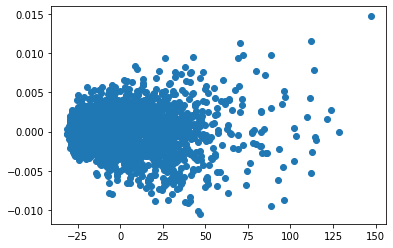

In [142]:
plt.scatter(df_embeddings_pca["X1"], df_embeddings_pca["X2"])

In [143]:
df_embeddings_UMAP = compute_dimensionality_reduction(latent_space, x_scaled, method = 'UMAP')
df_embeddings_UMAP.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.535433,8.159892
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.773101,16.700470
2,0.0,0.333333,0.0,0.0,0.0,0.111111,0.333333,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.267716,7.293403
3,0.0,0.000000,0.0,0.0,0.0,0.222222,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.458043,4.211179
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.939342,20.802290


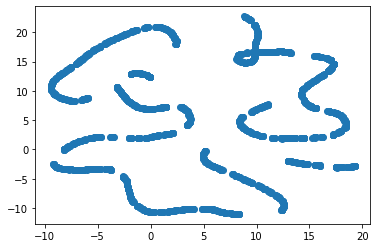

In [144]:
plt.scatter(df_embeddings_UMAP["X1"], df_embeddings_UMAP["X2"])

In [145]:
df_embeddings_tsne = compute_dimensionality_reduction(latent_space, x_scaled, method = 'TSNE')
df_embeddings_tsne.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.527893,55.268166
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.632069,22.996723
2,0.0,0.333333,0.0,0.0,0.0,0.111111,0.333333,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-23.578060,-22.654604
3,0.0,0.000000,0.0,0.0,0.0,0.222222,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.269584,19.497107
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.965004,42.871853


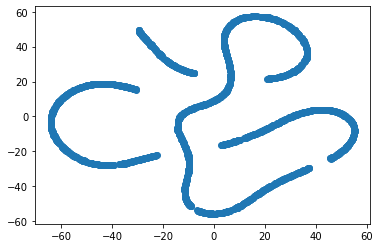

In [146]:
plt.scatter(df_embeddings_tsne["X1"], df_embeddings_tsne["X2"])

## D4

In [147]:
counts = pd.read_csv("/../../sbgenomics/project-files/data/counts_with_probes/D4_counts_with_probes.csv", index_col=0)
counts = counts.rename(columns = {"Unnamed: 0.1": "probes"})
counts = counts.set_index("probes")
counts_wo_xy = counts.drop(columns=["y_coord","x_coord"])

In [148]:
x_scaled = scale_datasets(counts_wo_xy)

In [149]:
model = AE()

In [150]:
n_epochs = 10
batch_size = 200
data_tensor = torch.Tensor(x_scaled.values)
train = torch.utils.data.TensorDataset(data_tensor, data_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

[1,    12] loss: 0.2107
[2,    12] loss: 0.2055
[3,    12] loss: 0.1885
[4,    12] loss: 0.1122
[5,    12] loss: 0.0352
[6,    12] loss: 0.0256
[7,    12] loss: 0.0237
[8,    12] loss: 0.0230
[9,    12] loss: 0.0226
[10,    12] loss: 0.0226
Finished Training


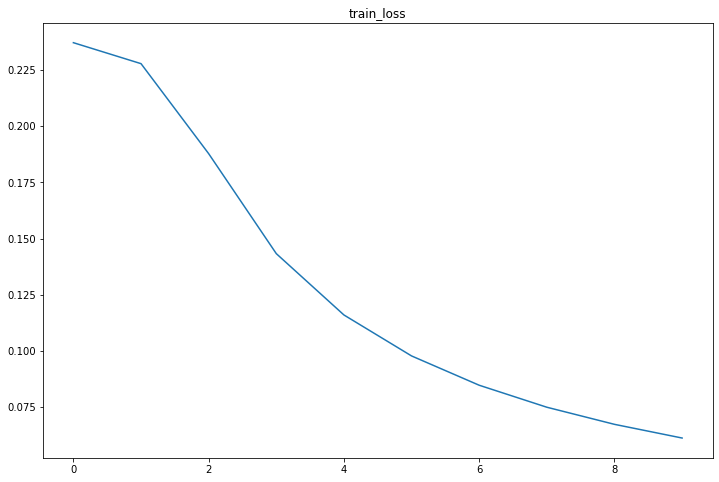

In [151]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00001)

losses = []
for epoch in range(n_epochs):
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs.to(device)

        # forward pass
        outputs = model(inputs)
        
        # defining loss
        loss = criterion(outputs, inputs)
        
        # zero to parameter gradients
        optimizer.zero_grad()

        # computing gradients
        loss.backward()
        
        # accumulating running loss
        running_loss += loss.item()
        
        # updated weights based on computed gradients
        optimizer.step()

        losses.append(loss)
        
    print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / (i + 1)))
print('Finished Training')
plt.figure(figsize=(12, 8))
plt.plot(train_epoch_loss)
plt.title('train_loss')
plt.show()

In [152]:
latent_space = get_embeddings(x_scaled, model, 10)
latent_space

array([[  4.314256  ,   0.9978361 ,  -4.3259196 , ...,  -0.4851215 ,
         11.85782   ,   2.925083  ],
       [  2.9096365 ,   0.69545823,  -2.9117744 , ...,  -0.33757058,
          7.9698553 ,   1.9599806 ],
       [ 11.666293  ,   2.6174197 , -11.691457  , ...,  -1.277468  ,
         32.16223   ,   7.949273  ],
       ...,
       [  1.1090426 ,   0.2999653 ,  -1.1090913 , ...,  -0.14435914,
          2.994933  ,   0.7303297 ],
       [  2.3435855 ,   0.5705436 ,  -2.343133  , ...,  -0.27435583,
          6.4047956 ,   1.57588   ],
       [  8.054552  ,   1.8234107 ,  -8.070022  , ...,  -0.8852365 ,
         22.19406   ,   5.4840183 ]], dtype=float32)

In [153]:
df_latent_space = pd.DataFrame(latent_space, columns = ['dim_1','dim_2','dim_3','dim_4','dim_5','dim_6','dim_7','dim_8','dim_9','dim_10'])
df_latent_space.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10
0,4.314256,0.997836,-4.325920,12.710563,-6.869707,-3.516137,5.157725,-0.485121,11.857820,2.925083
1,2.909636,0.695458,-2.911774,8.521015,-4.639354,-2.362587,3.477324,-0.337571,7.969855,1.959981
2,11.666293,2.617420,-11.691457,34.609249,-18.527084,-9.566725,13.897985,-1.277468,32.162231,7.949273
3,5.243831,1.205250,-5.251267,15.473411,-8.344607,-4.279756,6.260279,-0.586554,14.422358,3.558549
4,9.795835,2.205875,-9.817062,29.038006,-15.556287,-8.032812,11.682899,-1.079019,26.996796,6.669477


In [154]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/latent_space"
os.makedirs(sevenbg_output_path, exist_ok=True)
df_latent_space.to_csv(f"{sevenbg_output_path}/D4_latent_space.csv")

In [155]:
df_embeddings_pca = compute_dimensionality_reduction(latent_space, x_scaled, method = 'PCA')
df_embeddings_pca.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.4,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.413994,0.004713
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-21.256124,-0.003691
2,0.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.328321,-0.007193
3,0.0,0.4,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.901888,0.002352
4,0.0,0.6,0.0,0.0,0.0,0.285714,0.0,0.428571,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.236349,-0.006120


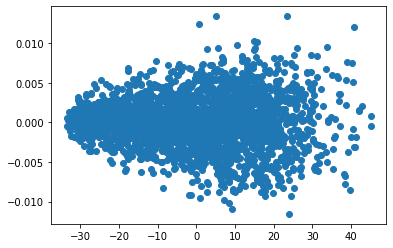

In [156]:
plt.scatter(df_embeddings_pca["X1"], df_embeddings_pca["X2"])

In [157]:
df_embeddings_UMAP = compute_dimensionality_reduction(latent_space, x_scaled, method = 'UMAP')
df_embeddings_UMAP.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.4,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.170044,0.825686
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.025954,-1.984671
2,0.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.189444,-4.264725
3,0.0,0.4,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.074354,8.143809
4,0.0,0.6,0.0,0.0,0.0,0.285714,0.0,0.428571,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.366137,6.497928


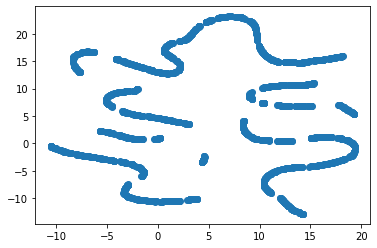

In [158]:
plt.scatter(df_embeddings_UMAP["X1"], df_embeddings_UMAP["X2"])

In [159]:
df_embeddings_tsne = compute_dimensionality_reduction(latent_space, x_scaled, method = 'TSNE')
df_embeddings_tsne.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D,X1,X2
0,0.0,0.4,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.594210,26.144245
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-45.289200,18.007692
2,0.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.470589,-35.396782
3,0.0,0.4,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.099022,2.614878
4,0.0,0.6,0.0,0.0,0.0,0.285714,0.0,0.428571,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-42.757683,-33.741570


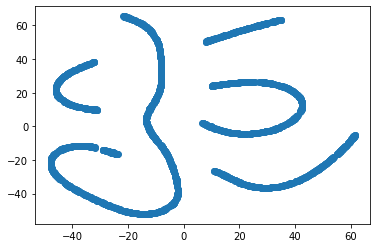

In [160]:
plt.scatter(df_embeddings_tsne["X1"], df_embeddings_tsne["X2"])